In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from utils import *
from cat_whim.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR, REPORTS_DIR, FIGURES_DIR, BIDS_DATA_DIR

In [6]:
sns.set_palette("tab10")

# Main analyses

In [7]:
df_filename = PROCESSED_DATA_DIR / "df_cat_whim_to_analyze.csv"
dk_regions_filename = PROCESSED_DATA_DIR / "dk_region_names.csv"
roi_adsig_filename = PROCESSED_DATA_DIR / "ad_signature_mayo_rois.csv"

# Load data
df = pd.read_csv(df_filename)
df = df[df["session"] != "M02"].reset_index(drop=True).copy()
df = df[~df["RAVLT_forgetting"].isnull()].copy()
df = df[df["RAVLT_forgetting"] > -10].copy()
dk_region_labels = pd.read_csv(dk_regions_filename).values.flatten()
df["CTX_ETIV"] = df["CTX_ETIV"] / 1000000 # scale down too same order of magnitude as other variables
# ADsig Mayo from Clifford et al Brain 2015 (as reported by Parker et al in Alzh & Dem)
adsig_mayo = pd.read_csv(
    roi_adsig_filename
).columns.to_list()  
adsig_control = ["CTX_LH_PARAHIPPOCAMPAL", "CTX_RH_PARAHIPPOCAMPAL",
                       "CTX_LH_TEMPORALPOLE", "CTX_RH_TEMPORALPOLE",
                       "CTX_LH_INFERIORPARIETAL", "CTX_RH_INFERIORPARIETAL", 
                       "CTX_LH_PARSOPERCULARIS", "CTX_RH_PARSOPERCULARIS",
                       "CTX_LH_PARSORBITALIS", "CTX_RH_PARSORBITALIS",
                       "CTX_LH_PARSTRIANGULARIS", "CTX_RH_PARSTRIANGULARIS",
                       "CTX_LH_PRECUNEUS", "CTX_RH_PRECUNEUS",
                       "CTX_LH_SUPRAMARGINAL", "CTX_RH_SUPRAMARGINAL",
                       "CTX_LH_SUPERIORPARIETAL", "CTX_RH_SUPERIORPARIETAL",
                       "CTX_LH_SUPERIORFRONTAL", "CTX_RH_SUPERIORFRONTAL",
                       "CTX_LH_PRECENTRAL", "CTX_RH_PRECENTRAL", 
                       "CTX_LH_POSTCENTRAL", "CTX_RH_POSTCENTRAL"]

# Labels for region names
region_names_adsig = ["Entorhinal", "Fusiform", "Inferior Temporal", "Middle Temporal"]
region_names_control = ["Parahippocampal",
                            "Temporal Pole",
                            "Inferior Parietal",
                            "Pars Opercularis",
                            "Pars Orbitalis",
                            "Pars Triangularis",
                            "Precuneus", 
                            "Supramarginal",
                            "Superior Parietal",
                            "Superior Frontal",
                            "Pre-Central", 
                            "Post-central"]

# Get the region names for each biomarker
amy_cols = [region + "_SUVR_amy" for region in dk_region_labels]
tau_cols = [region + "_SUVR_tau" for region in dk_region_labels]
disconn_cols = [region + "_disconn" for region in dk_region_labels]
thick_cols = [region + "_THICKNESS" for region in dk_region_labels]

# Load the wmh datas
wmh = pd.read_csv(INTERIM_DATA_DIR / "df_wmh_vols.csv")
wmh["session"] = wmh["session"].apply(lambda x: x.split("-")[1])
df = df.merge(wmh, on=["PTID", "session"])
    
# Check that all subjects with M01 also have baseline
subjs_m01 = df[df["session"] == "M01"]["PTID"].unique()
subjs_m00 = df[df["session"] == "M00"]["PTID"].unique()
missing_baseline = [pt for pt in subjs_m01 if pt not in subjs_m00]
df = df[~df["PTID"].isin(missing_baseline)].copy()
df["wmh_vol_log"] = np.log10(
    df["wmh_vol"], where=(df["wmh_vol"] != 0), out=np.zeros_like(df["wmh_vol"])
)


/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# Gather the data on deep vs. periventricular WMH volumes 
df_wmh_pv_deep = pd.read_csv(INTERIM_DATA_DIR / "df_wmh_vols_pv_deep.csv")
df_wmh_pv_deep["session"] = df_wmh_pv_deep["session"].apply(lambda x: x.split("-")[1])
df_wmh_pv_deep["wmh_vol_deep_log"] = np.log10(df_wmh_pv_deep["wmh_vol_deep"], where=(df_wmh_pv_deep["wmh_vol_deep"] != 0), out = np.zeros_like(df_wmh_pv_deep["wmh_vol_deep"]))
df_wmh_pv_deep["wmh_vol_pv_log"] = np.log10(df_wmh_pv_deep["wmh_vol_pv"], where=(df_wmh_pv_deep["wmh_vol_pv"] != 0), out = np.zeros_like(df_wmh_pv_deep["wmh_vol_pv"]))
df_m00 = df[df["session"] == "M00"].copy()
df_m00 = pd.merge(df_m00, df_wmh_pv_deep, on = ["PTID", "session"])

/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
df_wmh_pv_deep1 = pd.read_csv(INTERIM_DATA_DIR / "df_wmh_vols_pv_deep_ses-M01.csv")
df_wmh_pv_deep1["session"] = df_wmh_pv_deep1["session"].apply(lambda x: x.split("-")[1])
df_wmh_pv_deep1["wmh_vol_deep_log"] = np.log10(df_wmh_pv_deep1["wmh_vol_deep"], where=(df_wmh_pv_deep1["wmh_vol_deep"] != 0), out = np.zeros_like(df_wmh_pv_deep1["wmh_vol_deep"]))
df_wmh_pv_deep1["wmh_vol_pv_log"] = np.log10(df_wmh_pv_deep1["wmh_vol_pv"], where=(df_wmh_pv_deep1["wmh_vol_pv"] != 0), out = np.zeros_like(df_wmh_pv_deep1["wmh_vol_pv"]))

/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df_wmh_pv_deep_complete = pd.concat([df_wmh_pv_deep, df_wmh_pv_deep1], ignore_index=True)
df_l = df.merge(df_wmh_pv_deep_complete, on=["PTID", "session"], how="left")

/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


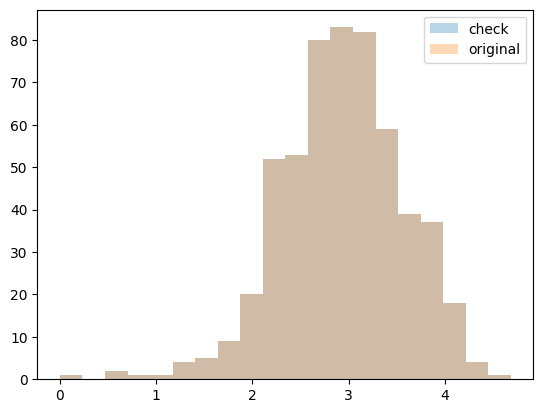

In [11]:
# Double check that the sum of deep + pv is equal to total wmh
df_m00["wmh_vol_check"] = df_m00["wmh_vol_deep"] + df_m00["wmh_vol_pv"]
df_m00["wmh_vol_check_log"] = np.log10(
    df_m00["wmh_vol_check"], where=(df_m00["wmh_vol_check"] != 0), out=np.zeros_like(df_m00["wmh_vol"])
)

plt.hist(df_m00["wmh_vol_check_log"], bins=20, label="check", alpha = 0.3);
plt.hist(df_m00["wmh_vol_log"], bins=20, label = "original", alpha = 0.3);

plt.legend()

In [12]:
# Create demographics table and add the pv and deep wmh volumes
table = make_demographics_table(df)
deep_wmh = f"{np.quantile(df_wmh_pv_deep['wmh_vol_deep_log'], 0.5):.2f} ({np.quantile(df_wmh_pv_deep['wmh_vol_deep_log'], 0.25):.2f} - {np.quantile(df_wmh_pv_deep['wmh_vol_deep_log'], 0.75):.2f})"
pv_wmh = f"{np.quantile(df_wmh_pv_deep['wmh_vol_pv_log'], 0.5):.2f} ({np.quantile(df_wmh_pv_deep['wmh_vol_pv_log'], 0.25):.2f} - {np.quantile(df_wmh_pv_deep['wmh_vol_pv_log'], 0.75):.2f})"
table_deep_wmh = pd.DataFrame({"Variable": "Deep WMH vol. (log)", "All (n = 551)": deep_wmh}, index=[0])
table_pv_wmh = pd.DataFrame({"Variable": "PV WMH vol. (log)", "All (n = 551)": pv_wmh}, index=[0])
new_order = [0,1,2,3,15,16,4,5,6,7,8,9,10,11,12,13,14]
table = pd.concat([table, table_deep_wmh, table_pv_wmh]).reset_index(drop=True).iloc[new_order, :].reset_index(drop=True)
table

AGE mean (SD)


,Variable,All (n = 551)
0,AGE,71.73 ± 7.32
1,PTEDUCAT,16.00 (15.00 - 18.00)
2,MMSE,29.00 (28.00 - 30.00)
3,wmh_vol_log,2.95 (2.52 - 3.36)
4,Deep WMH vol. (log),2.22 (1.73 - 2.66)
5,PV WMH vol. (log),2.93 (2.43 - 3.39)
6,RAVLT_forgetting,4.00 (2.00 - 6.00)
7,PTGENDER,
8,PTGENDER - Female,302 (54.8%)
9,PTGENDER - Male,249 (45.2%)


In [13]:
print("--------------------------------------------")
print("AMYLOID-POSITIVE")
print("--------------------------------------------")
make_demographics_table(df[df["AMYLOID_STATUS"] == 1])

--------------------------------------------
AMYLOID-POSITIVE
--------------------------------------------
AGE mean (SD)
wmh_vol_log mean (SD)


,Variable,All (n = 201)
0,AGE,73.31 ± 7.04
1,PTEDUCAT,16.00 (15.00 - 18.00)
2,MMSE,29.00 (27.00 - 30.00)
3,wmh_vol_log,3.03 ± 0.61
4,RAVLT_forgetting,5.00 (3.00 - 6.00)
5,PTGENDER,
6,PTGENDER - Female,115 (57.2%)
7,PTGENDER - Male,86 (42.8%)
8,DX,
9,DX - CN,102 (50.7%)


In [14]:
adsig_avg_mayo = []

for region in adsig_mayo:
    region_name = region.split("_")[-1]
    left_region = f"CTX_LH_{region_name}"
    right_region = f"CTX_RH_{region_name}"
    df_m00[f"{region_name}_disconn"] = (
        df_m00[f"{left_region}_disconn"] + df_m00[f"{right_region}_disconn"]
    ) / 2
    df_m00[f"{region_name}_THICKNESS"] = (
        df_m00[f"{left_region}_THICKNESS"] + df_m00[f"{right_region}_THICKNESS"]
    ) / 2
    df_m00[f"{region_name}_SUVR_tau"] = (
        df_m00[f"{left_region}_SUVR_tau"] + df_m00[f"{right_region}_SUVR_tau"]
    ) / 2
    df_m00[f"{region_name}_SUVR_amy"] = (
        df_m00[f"{left_region}_SUVR_amy"] + df_m00[f"{right_region}_SUVR_amy"]
    ) / 2
    if not region_name in adsig_avg_mayo:
        adsig_avg_mayo.append(region_name)

In [15]:
adsig_avg_control = []

for region in adsig_control:
    region_name = region.split("_")[-1]
    left_region = f"CTX_LH_{region_name}"
    right_region = f"CTX_RH_{region_name}"
    df_m00[f"{region_name}_disconn"] = (
        df_m00[f"{left_region}_disconn"] + df_m00[f"{right_region}_disconn"]
    ) / 2
    df_m00[f"{region_name}_THICKNESS"] = (
        df_m00[f"{left_region}_THICKNESS"] + df_m00[f"{right_region}_THICKNESS"]
    ) / 2
    df_m00[f"{region_name}_SUVR_tau"] = (
        df_m00[f"{left_region}_SUVR_tau"] + df_m00[f"{right_region}_SUVR_tau"]
    ) / 2
    df_m00[f"{region_name}_SUVR_amy"] = (
        df_m00[f"{left_region}_SUVR_amy"] + df_m00[f"{right_region}_SUVR_amy"]
    ) / 2
    if not region_name in adsig_avg_control:
        adsig_avg_control.append(region_name)

In [16]:
LQT_DIR = BIDS_DATA_DIR / "derivatives" / "LQT" / "results"

disconn_all = []

for subdir in LQT_DIR.iterdir():

    if subdir.is_dir() and subdir.name.startswith("ADNI") and subdir.name.endswith("M00"):
        subid = "sub-" + subdir.name.split("_")[0]
        sesid = subdir.name.split("_")[1]
        if subid in df_m00["PTID"].values:
            discon_filename = f"{subid}_{sesid}_pct_sdc_matrix.csv"
            disconn = pd.read_csv(subdir / discon_filename, index_col=0).values[:68, :68]
            disconn_all.append(disconn)

disconn_all_mean = np.mean(disconn_all, axis=0)
disconn_all_mean = pd.DataFrame(disconn_all_mean, index=dk_region_labels, columns=dk_region_labels)
disconn_all_mean.to_csv(PROCESSED_DATA_DIR / "average_disconnectivity_matrix.csv")

In [17]:
adsig_mayo_disconn = [col + "_disconn" for col in adsig_avg_mayo]
df_m00_mayo_disconn = df_m00[adsig_mayo_disconn].copy()
df_m00_mayo_disconn_mean = df_m00_mayo_disconn.mean(axis=0)
df_m00_mayo_disconn_mean_sorted_asc = df_m00_mayo_disconn_mean.sort_values(ascending=True)
dict_region_map = dict(zip(adsig_avg_mayo, region_names_adsig))

In [18]:
adsig_control_disconn = [col + "_disconn" for col in adsig_avg_control]
df_m00_control_disconn = df_m00[adsig_control_disconn].copy()
df_m00_control_disconn_mean = df_m00_control_disconn.mean(axis=0)
df_m00_control_disconn_mean_sorted_asc = df_m00_control_disconn_mean.sort_values(ascending=True)
dict_region_map_control = dict(zip(adsig_avg_control, region_names_control))

/tmp/ipykernel_854288/118688306.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(new_ytick_labels, ha='right')
/tmp/ipykernel_854288/118688306.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(new_ytick_labels, ha='right')


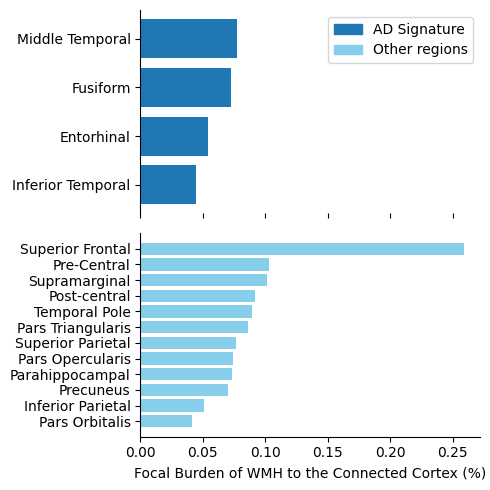

In [19]:
fig, axs = plt.subplots(2,1, figsize=(5, 5), sharex=True)

axs[0].barh(df_m00_mayo_disconn_mean_sorted_asc.index, df_m00_mayo_disconn_mean_sorted_asc.values, color="tab:blue")
axs[1].barh(df_m00_control_disconn_mean_sorted_asc.index, df_m00_control_disconn_mean_sorted_asc.values, color="skyblue")

current_ytick_labels = df_m00_mayo_disconn_mean_sorted_asc.index.tolist()
new_ytick_labels = []
for label_with_disconn in current_ytick_labels:
    base_label = label_with_disconn.replace('_disconn', '')
    new_ytick_labels.append(dict_region_map.get(base_label, base_label))
axs[0].set_yticklabels(new_ytick_labels, ha='right')

current_ytick_labels = df_m00_control_disconn_mean_sorted_asc.index.tolist()
new_ytick_labels = []
for label_with_disconn in current_ytick_labels:
    base_label = label_with_disconn.replace('_disconn', '')
    new_ytick_labels.append(dict_region_map_control.get(base_label, base_label))
axs[1].set_yticklabels(new_ytick_labels, ha='right')

axs[1].set_xlabel("Focal Burden of WMH to the Connected Cortex (%)")

# Create a specific legend
red_patch = mpatches.Patch(color='tab:blue', label='AD Signature')
blue_patch = mpatches.Patch(color='skyblue', label='Other regions')
axs[0].legend(handles=[red_patch, blue_patch])

for i,spine in enumerate(axs[0].spines.values()):
    if i == 0:

        spine.set_color("black")
    else:
        spine.set_color("none")


for i,spine in enumerate(axs[1].spines.values()):
    if i == 0 or i == 2:
        spine.set_color("black")
    else:
        spine.set_color("none")

fig.tight_layout()
fig.savefig(FIGURES_DIR / "barplot_disconnectivity.svg", dpi=300)

In [20]:
df_m00_amy = df_m00[df_m00["AMYLOID_STATUS"] == 1].copy()

In [21]:
print("GB-WMH all sample cross-sectional basis ADSIG MAYO")
calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis")

GB-WMH all sample cross-sectional basis ADSIG MAYO


GB-WMH                                               \
              region      N            Beta (95% CI)   p-val p-val (FDR)   
0         Entorhinal    551   -0.013 (-0.051, 0.025)     0.5         0.5   
1           Fusiform    551  -0.025 (-0.041, -0.008)  0.0032       0.013   
2  Inferior temporal    551  -0.020 (-0.037, -0.002)   0.027       0.036   
3    Middle temporal    551  -0.020 (-0.037, -0.004)   0.015        0.03   

                  Amyloid                                          Tau  \
            Beta (95% CI)   p-val p-val (FDR)            Beta (95% CI)   
0    0.307 (0.094, 0.520)  0.0048       0.019  -0.319 (-0.379, -0.259)   
1    0.074 (0.015, 0.133)   0.014       0.028  -0.092 (-0.119, -0.065)   
2   0.011 (-0.042, 0.064)    0.68        0.82  -0.063 (-0.090, -0.037)   
3  -0.006 (-0.056, 0.044)    0.82        0.82  -0.074 (-0.101, -0.047)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [22]:
print("GB-WMH amyloid cross-sectional basis ADSIG MAYO")
calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis")

GB-WMH amyloid cross-sectional basis ADSIG MAYO


GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    201  -0.068 (-0.132, -0.003)  0.039       0.039   
1           Fusiform    201  -0.042 (-0.076, -0.009)  0.014       0.028   
2  Inferior temporal    201  -0.037 (-0.070, -0.004)   0.03       0.039   
3    Middle temporal    201  -0.040 (-0.071, -0.009)  0.011       0.028   

                  Amyloid                                        Tau  \
            Beta (95% CI) p-val p-val (FDR)            Beta (95% CI)   
0   0.132 (-0.184, 0.448)  0.41        0.62  -0.230 (-0.306, -0.153)   
1   0.040 (-0.063, 0.143)  0.44        0.62  -0.097 (-0.131, -0.062)   
2  -0.027 (-0.117, 0.062)  0.55        0.62  -0.068 (-0.100, -0.037)   
3  -0.022 (-0.111, 0.067)  0.62        0.62  -0.083 (-0.115, -0.050)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [23]:
print("pvGB-WMH all sample cross-sectional basis ADSIG MAYO")
calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis")

pvGB-WMH all sample cross-sectional basis ADSIG MAYO


GB-WMH                                               \
              region      N            Beta (95% CI)   p-val p-val (FDR)   
0         Entorhinal    551   -0.007 (-0.040, 0.027)     0.7         0.7   
1           Fusiform    551  -0.019 (-0.034, -0.005)  0.0095       0.028   
2  Inferior temporal    551  -0.019 (-0.035, -0.004)   0.014       0.028   
3    Middle temporal    551  -0.016 (-0.030, -0.002)    0.03       0.039   

                  Amyloid                                          Tau  \
            Beta (95% CI)   p-val p-val (FDR)            Beta (95% CI)   
0    0.309 (0.096, 0.521)  0.0046       0.018  -0.319 (-0.380, -0.259)   
1    0.075 (0.016, 0.134)   0.012       0.025  -0.092 (-0.119, -0.065)   
2   0.012 (-0.041, 0.065)    0.66        0.83  -0.063 (-0.090, -0.037)   
3  -0.005 (-0.056, 0.045)    0.83        0.83  -0.074 (-0.101, -0.047)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [24]:
print("pvGB-WMH amyloid cross-sectional basis ADSIG MAYO")
calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis")

pvGB-WMH amyloid cross-sectional basis ADSIG MAYO


GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    201   -0.044 (-0.102, 0.013)   0.13        0.13   
1           Fusiform    201  -0.034 (-0.064, -0.004)  0.025       0.034   
2  Inferior temporal    201  -0.036 (-0.065, -0.007)  0.016       0.034   
3    Middle temporal    201  -0.033 (-0.061, -0.006)  0.017       0.034   

                  Amyloid                                        Tau  \
            Beta (95% CI) p-val p-val (FDR)            Beta (95% CI)   
0   0.138 (-0.180, 0.455)  0.39        0.69  -0.230 (-0.307, -0.153)   
1   0.044 (-0.059, 0.147)   0.4        0.69  -0.097 (-0.131, -0.062)   
2  -0.024 (-0.113, 0.065)   0.6        0.69  -0.068 (-0.099, -0.037)   
3  -0.018 (-0.107, 0.071)  0.69        0.69  -0.083 (-0.116, -0.051)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [25]:
print("dGB-WMH all sample cross-sectional basis ADSIG MAYO")
calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis")

dGB-WMH all sample cross-sectional basis ADSIG MAYO


GB-WMH                                             \
              region      N           Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    551  -0.003 (-0.032, 0.026)   0.84        0.84   
1           Fusiform    551  -0.012 (-0.025, 0.000)  0.057        0.23   
2  Inferior temporal    551  -0.006 (-0.019, 0.008)   0.41        0.55   
3    Middle temporal    551  -0.006 (-0.018, 0.007)   0.36        0.55   

                  Amyloid                                          Tau  \
            Beta (95% CI)   p-val p-val (FDR)            Beta (95% CI)   
0    0.310 (0.097, 0.523)  0.0044       0.018  -0.320 (-0.380, -0.260)   
1    0.074 (0.015, 0.133)   0.015       0.029  -0.093 (-0.120, -0.066)   
2   0.010 (-0.043, 0.063)    0.71        0.77  -0.064 (-0.091, -0.037)   
3  -0.008 (-0.058, 0.043)    0.77        0.77  -0.074 (-0.101, -0.046)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [26]:
print("dGB-WMH amyloid cross-sectional basis ADSIG MAYO")
calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis")

dGB-WMH amyloid cross-sectional basis ADSIG MAYO


GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    201  -0.053 (-0.101, -0.005)  0.032        0.13   
1           Fusiform    201   -0.021 (-0.046, 0.005)   0.11        0.22   
2  Inferior temporal    201   -0.007 (-0.032, 0.018)    0.6         0.6   
3    Middle temporal    201   -0.009 (-0.033, 0.014)   0.45         0.6   

                  Amyloid                                        Tau  \
            Beta (95% CI) p-val p-val (FDR)            Beta (95% CI)   
0   0.117 (-0.199, 0.434)  0.47        0.62  -0.228 (-0.304, -0.151)   
1   0.038 (-0.066, 0.142)  0.47        0.62  -0.099 (-0.134, -0.065)   
2  -0.026 (-0.117, 0.065)  0.57        0.62  -0.071 (-0.102, -0.039)   
3  -0.023 (-0.113, 0.068)  0.62        0.62  -0.084 (-0.117, -0.051)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [27]:
z_score_res_gb = calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")
z_score_res_pvgb = calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis_zscore")
z_score_res_dgb = calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis_zscore")

In [28]:
z_score_res_gb_amy = calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")
z_score_res_pvgb_amy = calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis_zscore")
z_score_res_dgb_amy = calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis_zscore")

In [29]:
print("GB-WMH all sample cross-sectional basis OTHER REGIONS")
calculate_cross_sectional_associations(df_m00, adsig_avg_control, region_names_control, "wmh_vol_log", analysis_type="basis")

GB-WMH all sample cross-sectional basis OTHER REGIONS


GB-WMH                                               \
               region      N            Beta (95% CI)   p-val p-val (FDR)   
0     Parahippocampal    551   -0.007 (-0.037, 0.023)    0.65        0.76   
1       Temporal pole    551   -0.020 (-0.056, 0.017)    0.29        0.44   
2   Inferior parietal    551   -0.005 (-0.018, 0.009)    0.49        0.66   
3    Pars opercularis    551   -0.014 (-0.027, 0.000)   0.054        0.17   
4      Pars orbitalis    551   -0.018 (-0.038, 0.002)   0.071        0.17   
5   Pars triangularis    551  -0.019 (-0.033, -0.005)  0.0067       0.049   
6           Precuneus    551   -0.003 (-0.016, 0.011)     0.7        0.76   
7       Supramarginal    551  -0.019 (-0.033, -0.005)  0.0082       0.049   
8   Superior parietal    551    0.011 (-0.004, 0.026)    0.16        0.33   
9    Superior frontal    551   -0.009 (-0.025, 0.006)    0.22        0.38   
10        Pre-central    551   -0.016 (-0.033, 0.001)   0.071        0.17   
11       Post-central    551   -0.001 (-0.016, 0.013)    0.87        0.87   

                   Amyloid                                         Tau  \
             Beta (95% CI)  p-val p-val (FDR)            Beta (95% CI)   
0    0.015 (-0.124, 0.153)   0.84        0.84  -0.076 (-0.138, -0.015)   
1    0.093 (-0.053, 0.239)   0.21        0.84  -0.246 (-0.338, -0.155)   
2   -0.031 (-0.070, 0.008)   0.12        0.69  -0.050 (-0.072, -0.028)   
3    0.009 (-0.030, 0.048)   0.65        0.84   -0.024 (-0.062, 0.013)   
4   -0.010 (-0.061, 0.041)   0.71        0.84    0.014 (-0.063, 0.091)   
5   -0.007 (-0.044, 0.031)   0.73        0.84    0.032 (-0.020, 0.083)   
6   -0.030 (-0.063, 0.004)  0.083        0.69  -0.065 (-0.094, -0.035)   
7    0.004 (-0.038, 0.046)   0.84        0.84  -0.056 (-0.088, -0.024)   
8   -0.011 (-0.059, 0.037)   0.65        0.84  -0.059 (-0.090, -0.029)   
9   -0.015 (-0.058, 0.027)   0.48        0.84   -0.027 (-0.080, 0.025)   
10  -0.036 (-0.108, 0.037)   0.33        0.84    0.012 (-0.069, 0.092)   
11   0.010 (-0.047, 0.066)   0.74        0.84     0.089 (0.013, 0.165)   

                            
         p-val p-val (FDR)  
0        0.015       0.031  
1   p < 0.0001  p < 0.0001  
2   p < 0.0001  p < 0.0001  
3          0.2         0.3  
4         0.72        0.77  
5         0.23        0.31  
6   p < 0.0001  p < 0.0001  
7      0.00066      0.0016  
8      0.00014     0.00041  
9          0.3        0.36  
10        0.77        0.77  
11       0.021       0.036

In [30]:
print("GB-WMH amyloid cross-sectional basis OTHER REGIONS")
calculate_cross_sectional_associations(df_m00_amy, adsig_avg_control, region_names_control, "wmh_vol_log", analysis_type="basis")

GB-WMH amyloid cross-sectional basis OTHER REGIONS


GB-WMH                                               \
               region      N            Beta (95% CI)   p-val p-val (FDR)   
0     Parahippocampal    201   -0.010 (-0.064, 0.043)     0.7         0.7   
1       Temporal pole    201   -0.061 (-0.126, 0.004)   0.067        0.31   
2   Inferior parietal    201   -0.009 (-0.034, 0.016)    0.47        0.52   
3    Pars opercularis    201   -0.017 (-0.042, 0.008)    0.18        0.31   
4      Pars orbitalis    201   -0.021 (-0.056, 0.014)    0.23        0.31   
5   Pars triangularis    201   -0.021 (-0.047, 0.005)    0.11        0.31   
6           Precuneus    201   -0.018 (-0.043, 0.007)    0.15        0.31   
7       Supramarginal    201   -0.021 (-0.046, 0.004)     0.1        0.31   
8   Superior parietal    201    0.014 (-0.016, 0.044)    0.34        0.41   
9    Superior frontal    201   -0.019 (-0.047, 0.010)     0.2        0.31   
10        Pre-central    201  -0.047 (-0.079, -0.015)  0.0044       0.052   
11       Post-central    201   -0.017 (-0.044, 0.010)    0.21        0.31   

                   Amyloid                                         Tau  \
             Beta (95% CI)  p-val p-val (FDR)            Beta (95% CI)   
0     0.262 (0.043, 0.480)  0.019        0.23  -0.103 (-0.176, -0.030)   
1   -0.122 (-0.340, 0.096)   0.27        0.88  -0.180 (-0.297, -0.063)   
2   -0.057 (-0.131, 0.016)   0.12        0.74  -0.055 (-0.081, -0.030)   
3    0.012 (-0.058, 0.082)   0.74        0.97   -0.040 (-0.082, 0.003)   
4   -0.011 (-0.104, 0.083)   0.82        0.97   -0.009 (-0.114, 0.096)   
5    0.005 (-0.066, 0.076)    0.9        0.97   -0.026 (-0.094, 0.041)   
6   -0.033 (-0.094, 0.028)   0.29        0.88  -0.069 (-0.101, -0.036)   
7    0.001 (-0.075, 0.077)   0.97        0.97  -0.072 (-0.108, -0.037)   
8   -0.041 (-0.133, 0.051)   0.38        0.89  -0.068 (-0.105, -0.030)   
9    0.004 (-0.077, 0.084)   0.93        0.97   -0.047 (-0.113, 0.019)   
10  -0.048 (-0.173, 0.076)   0.45        0.89   -0.027 (-0.132, 0.078)   
11  -0.014 (-0.108, 0.081)   0.78        0.97    0.016 (-0.085, 0.116)   

                            
         p-val p-val (FDR)  
0       0.0061       0.012  
1       0.0027      0.0064  
2   p < 0.0001      0.0003  
3        0.066        0.11  
4         0.86        0.86  
5         0.45        0.59  
6   p < 0.0001      0.0003  
7   p < 0.0001     0.00035  
8      0.00045      0.0013  
9         0.16        0.24  
10        0.61        0.73  
11        0.76        0.83

In [31]:
z_score_res_gb_others = calculate_cross_sectional_associations(df_m00, adsig_avg_control, region_names_control, "wmh_vol_log", analysis_type="basis_zscore")
z_score_res_gb_others_amy = calculate_cross_sectional_associations(df_m00_amy, adsig_avg_control, region_names_control, "wmh_vol_log", analysis_type="basis_zscore")

In [32]:
z_score_res_gb_amy_neg = calculate_cross_sectional_associations(df_m00[df_m00["AMYLOID_STATUS"] == 0], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")
z_score_res_gb_others_amy_neg = calculate_cross_sectional_associations(df_m00[df_m00["AMYLOID_STATUS"] == 0], adsig_avg_control, region_names_control, "wmh_vol_log", analysis_type="basis_zscore")

In [33]:
df_m00_cn = df_m00[df_m00["DX"] == "CN"].copy()
df_m00_mci = df_m00[df_m00["DX"] == "MCI"].copy()

z_score_res_gb_cn = calculate_cross_sectional_associations(df_m00_cn, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")
z_score_res_gb_mci = calculate_cross_sectional_associations(df_m00_mci, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")

In [34]:
display(calculate_cross_sectional_associations(df_m00_cn, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))
display(calculate_cross_sectional_associations(df_m00_mci, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))

GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    350   -0.027 (-0.070, 0.015)    0.2         0.2   
1           Fusiform    350  -0.019 (-0.039, -0.000)  0.048        0.19   
2  Inferior temporal    350   -0.013 (-0.034, 0.007)    0.2         0.2   
3    Middle temporal    350   -0.015 (-0.035, 0.005)   0.14         0.2   

                   Amyloid                                        Tau        \
             Beta (95% CI)  p-val p-val (FDR)           Beta (95% CI) p-val   
0  -0.362 (-0.642, -0.083)  0.011       0.045  -0.053 (-0.177, 0.071)   0.4   
1    0.067 (-0.011, 0.146)  0.091        0.18  -0.044 (-0.104, 0.016)  0.15   
2    0.038 (-0.035, 0.111)    0.3        0.41  -0.026 (-0.080, 0.029)  0.36   
3    0.029 (-0.044, 0.101)   0.44        0.44  -0.046 (-0.104, 0.011)  0.11   

               
  p-val (FDR)  
0         0.4  
1        0.31  
2         0.4  
3        0.31

GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    201    0.017 (-0.056, 0.089)   0.65        0.65   
1           Fusiform    201  -0.038 (-0.069, -0.006)  0.019        0.06   
2  Inferior temporal    201  -0.034 (-0.067, -0.001)  0.042        0.06   
3    Middle temporal    201  -0.029 (-0.058, -0.001)  0.045        0.06   

                  Amyloid                                              Tau  \
            Beta (95% CI)       p-val p-val (FDR)            Beta (95% CI)   
0    0.800 (0.476, 1.124)  p < 0.0001  p < 0.0001  -0.367 (-0.448, -0.287)   
1   0.076 (-0.020, 0.171)        0.12        0.24  -0.105 (-0.142, -0.069)   
2  -0.014 (-0.097, 0.070)        0.75        0.75  -0.071 (-0.108, -0.035)   
3  -0.036 (-0.110, 0.038)        0.34        0.45  -0.069 (-0.103, -0.034)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2     0.00015     0.00015  
3     0.00013     0.00015

In [35]:
display(calculate_cross_sectional_associations(df_m00_cn[df_m00_cn["AMYLOID_STATUS"] == 1], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))
display(calculate_cross_sectional_associations(df_m00_mci[df_m00_mci["AMYLOID_STATUS"] == 1], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))


z_score_res_gb_cn_amy = calculate_cross_sectional_associations(df_m00_cn[df_m00_cn["AMYLOID_STATUS"] == 1], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")
z_score_res_gb_mci_amy = calculate_cross_sectional_associations(df_m00_mci[df_m00_mci["AMYLOID_STATUS"] == 1], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_zscore")

GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    102  -0.100 (-0.184, -0.016)   0.02        0.04   
1           Fusiform    102   -0.035 (-0.082, 0.012)   0.14        0.14   
2  Inferior temporal    102   -0.040 (-0.086, 0.006)  0.087        0.12   
3    Middle temporal    102  -0.054 (-0.098, -0.010)  0.017        0.04   

                  Amyloid                                       Tau        \
            Beta (95% CI) p-val p-val (FDR)           Beta (95% CI) p-val   
0  -0.312 (-0.767, 0.142)  0.18        0.68   0.024 (-0.147, 0.195)  0.78   
1   0.039 (-0.110, 0.189)   0.6        0.68  -0.049 (-0.170, 0.072)  0.42   
2   0.027 (-0.104, 0.158)  0.68        0.68  -0.043 (-0.126, 0.040)   0.3   
3   0.048 (-0.082, 0.179)  0.46        0.68  -0.071 (-0.161, 0.018)  0.12   

               
  p-val (FDR)  
0        0.78  
1        0.56  
2        0.56  
3        0.47

GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal     99   -0.048 (-0.152, 0.055)   0.35        0.35   
1           Fusiform     99  -0.056 (-0.108, -0.003)  0.038        0.15   
2  Inferior temporal     99   -0.036 (-0.089, 0.018)   0.19         0.3   
3    Middle temporal     99   -0.029 (-0.077, 0.018)   0.23         0.3   

                  Amyloid                                        Tau  \
            Beta (95% CI) p-val p-val (FDR)            Beta (95% CI)   
0   0.359 (-0.104, 0.821)  0.13        0.51  -0.294 (-0.410, -0.179)   
1   0.023 (-0.139, 0.184)  0.78        0.78  -0.103 (-0.147, -0.059)   
2  -0.067 (-0.207, 0.073)  0.34        0.54  -0.067 (-0.111, -0.024)   
3  -0.057 (-0.192, 0.078)   0.4        0.54  -0.076 (-0.118, -0.033)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2      0.0029      0.0029  
3     0.00071     0.00095

In [36]:
print("GB-WMH all sample cross-sectional reduced model ADSIG MAYO")
calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="sensitivity_less_covariates")

GB-WMH all sample cross-sectional reduced model ADSIG MAYO


GB-WMH                                               \
              region      N            Beta (95% CI)   p-val p-val (FDR)   
0         Entorhinal    551   -0.022 (-0.060, 0.016)    0.26        0.26   
1           Fusiform    551  -0.024 (-0.041, -0.008)  0.0034       0.014   
2  Inferior temporal    551  -0.019 (-0.036, -0.002)   0.033       0.044   
3    Middle temporal    551  -0.020 (-0.036, -0.004)   0.014       0.028   

                  Amyloid                                          Tau  \
            Beta (95% CI)   p-val p-val (FDR)            Beta (95% CI)   
0    0.291 (0.077, 0.504)  0.0077       0.031  -0.320 (-0.379, -0.260)   
1    0.070 (0.012, 0.129)   0.019       0.037  -0.091 (-0.117, -0.064)   
2   0.012 (-0.040, 0.065)    0.65        0.78  -0.063 (-0.090, -0.037)   
3  -0.007 (-0.057, 0.043)    0.78        0.78  -0.072 (-0.099, -0.045)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [37]:
print("GB-WMH amyloid cross-sectional reduced model ADSIG MAYO")
calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="sensitivity_less_covariates")

GB-WMH amyloid cross-sectional reduced model ADSIG MAYO


GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    201  -0.082 (-0.144, -0.019)  0.011       0.014   
1           Fusiform    201  -0.044 (-0.076, -0.012)  0.008       0.014   
2  Inferior temporal    201  -0.039 (-0.071, -0.008)  0.016       0.016   
3    Middle temporal    201  -0.040 (-0.070, -0.010)  0.009       0.014   

                  Amyloid                                        Tau  \
            Beta (95% CI) p-val p-val (FDR)            Beta (95% CI)   
0   0.149 (-0.159, 0.458)  0.34        0.57  -0.242 (-0.317, -0.167)   
1   0.037 (-0.064, 0.138)  0.47        0.57  -0.097 (-0.131, -0.063)   
2  -0.029 (-0.117, 0.060)  0.52        0.57  -0.068 (-0.099, -0.038)   
3  -0.025 (-0.113, 0.063)  0.57        0.57  -0.079 (-0.111, -0.047)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2  p < 0.0001  p < 0.0001  
3  p < 0.0001  p < 0.0001

In [38]:
all_amy_cols = [col + "_SUVR_amy" for col in dk_region_labels]
all_tau_cols = [col + "_SUVR_tau" for col in dk_region_labels]

df_m00["global_amy"] = df_m00[all_amy_cols].mean(axis=1)
df_m00["global_tau"] = df_m00[all_tau_cols].mean(axis=1)

calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="global_tau_amy")


GB-WMH                                               \
              region      N            Beta (95% CI)   p-val p-val (FDR)   
0         Entorhinal    551   -0.013 (-0.052, 0.025)     0.5         0.5   
1           Fusiform    551  -0.026 (-0.042, -0.009)  0.0021      0.0085   
2  Inferior temporal    551  -0.019 (-0.037, -0.002)   0.029       0.039   
3    Middle temporal    551  -0.019 (-0.035, -0.003)   0.022       0.039   

                   Amyloid                                         Tau  \
             Beta (95% CI)  p-val p-val (FDR)            Beta (95% CI)   
0    0.282 (-0.058, 0.621)    0.1        0.14  -0.347 (-0.427, -0.267)   
1   -0.083 (-0.244, 0.077)   0.31        0.31  -0.117 (-0.171, -0.063)   
2   -0.145 (-0.312, 0.021)  0.086        0.14   -0.048 (-0.103, 0.008)   
3  -0.233 (-0.420, -0.046)  0.015       0.059   -0.058 (-0.118, 0.002)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2       0.091       0.091  
3       0.059       0.079

In [39]:
df_m00_amy["global_amy"] = df_m00_amy[all_amy_cols].mean(axis=1)
df_m00_amy["global_tau"] = df_m00_amy[all_tau_cols].mean(axis=1)
calculate_cross_sectional_associations(df_m00_amy, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="global_tau_amy")

GB-WMH                                              \
              region      N            Beta (95% CI)  p-val p-val (FDR)   
0         Entorhinal    201  -0.066 (-0.130, -0.001)  0.046       0.046   
1           Fusiform    201  -0.041 (-0.075, -0.007)  0.018        0.04   
2  Inferior temporal    201  -0.036 (-0.070, -0.002)  0.036       0.046   
3    Middle temporal    201  -0.037 (-0.068, -0.006)   0.02        0.04   

                   Amyloid                                         Tau  \
             Beta (95% CI)  p-val p-val (FDR)            Beta (95% CI)   
0   -0.077 (-0.548, 0.394)   0.75        0.98  -0.210 (-0.313, -0.107)   
1    0.002 (-0.229, 0.233)   0.98        0.98  -0.123 (-0.196, -0.051)   
2   -0.082 (-0.308, 0.145)   0.48        0.96   -0.065 (-0.136, 0.006)   
3  -0.259 (-0.515, -0.003)  0.047        0.19   -0.076 (-0.154, 0.002)   

                           
        p-val p-val (FDR)  
0  p < 0.0001     0.00032  
1     0.00095      0.0019  
2       0.073       0.073  
3       0.056       0.073

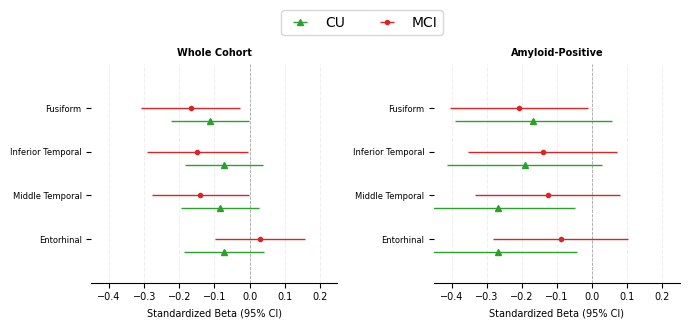

In [40]:
# Sort combined forest plot data

adsig_betas_cn, adsig_errors_cn = parse_beta_ci(z_score_res_gb_cn["GB-WMH"]["Beta (95% CI)"])
adsig_betas_mci, adsig_errors_mci = parse_beta_ci(z_score_res_gb_mci["GB-WMH"]["Beta (95% CI)"])

adsig_betas_cn_amy, adsig_errors_cn_amy = parse_beta_ci(z_score_res_gb_cn_amy["GB-WMH"]["Beta (95% CI)"])
adsig_betas_mci_amy, adsig_errors_mci_amy = parse_beta_ci(z_score_res_gb_mci_amy["GB-WMH"]["Beta (95% CI)"])

sorted_indices = np.argsort(adsig_betas_mci)

sorted_betas_mci = adsig_betas_mci[sorted_indices]
sorted_errors_mci = adsig_errors_mci[0][sorted_indices]
sorted_betas_cn = adsig_betas_cn[sorted_indices]
sorted_errors_cn = adsig_errors_cn[0][sorted_indices]


sorted_betas_mci_amy = adsig_betas_mci_amy[sorted_indices]
sorted_errors_mci_amy = adsig_errors_mci_amy[0][sorted_indices]
sorted_betas_cn_amy = adsig_betas_cn_amy[sorted_indices]
sorted_errors_cn_amy = adsig_errors_cn_amy[0][sorted_indices]

sorted_labels = [region_names_adsig[i] for i in sorted_indices]
sorted_weights = ['normal' for label in sorted_labels]

# Move forest plot to the second column (index 1), shift error bars to column 2
fig, axs = plt.subplots(1,2, figsize=(7, 3))

y_positions = np.arange(len(sorted_labels))[::-1]


for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas_cn, sorted_errors_cn, y_positions, sorted_weights)):
        axs[0].errorbar(
        beta, y-0.3,
        xerr=err, fmt='^', color="tab:green", capsize=0,
        markersize=4, elinewidth=1, capthick=1,
        zorder=2, label = "CU" if idx == 0 else None
    )

for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas_mci, sorted_errors_mci, y_positions, sorted_weights)):
        axs[0].errorbar(
        beta, y,
        xerr=err, fmt='o', color="tab:red", capsize=0,
        markersize=3, elinewidth=1, capthick=1,
        zorder=2, label = "MCI" if idx == 0 else None
    )        
            
for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas_mci_amy, sorted_errors_mci_amy, y_positions, sorted_weights)):
        axs[1].errorbar(
        beta, y,
        xerr=err, fmt='o', color="tab:red", capsize=0,
        markersize=3, elinewidth=1, capthick=1,
        zorder=2, label = None
    )
for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas_cn_amy, sorted_errors_cn_amy, y_positions, sorted_weights)):
        axs[1].errorbar(
        beta, y-0.3,
        xerr=err, fmt='^', color="tab:green", capsize=0,
        markersize=4, elinewidth=1, capthick=1,
        zorder=2, label = None
    )



# Format plot
axs[0].axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1, linewidth=0.6)
axs[0].set_yticks(y_positions)
axs[0].set_yticklabels(sorted_labels, fontsize=6, fontweight='normal')

axs[1].axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1, linewidth=0.6)
axs[1].set_yticks(y_positions)
axs[1].set_yticklabels(sorted_labels, fontsize=6, fontweight='normal')

# Apply bold font to AD signature regions
for tick_label, weight in zip(axs[0].get_yticklabels(), sorted_weights):
    tick_label.set_fontweight(weight)

for tick_label, weight in zip(axs[1].get_yticklabels(), sorted_weights):
    tick_label.set_fontweight(weight)

for i,ax in enumerate(axs.flatten()):

    titles = ["Whole Cohort", "Amyloid-Positive"]

    ax.set_xlabel('Standardized Beta (95% CI)', fontsize=7)
    ax.set_xlim(-0.45, 0.25)
    ax.set_ylim(-1, len(sorted_labels))
    ax.tick_params(axis='x', labelsize=7)
    ax.grid(False, axis='y')
    ax.grid(axis='x', linestyle='--', alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(titles[i], fontsize=7, fontweight='bold', loc='center')

fig.legend(ncol=2, bbox_to_anchor=(0.65, 1.1))
fig.tight_layout()
fig.savefig(REPORTS_DIR / "figures" / "cu_vs_mci_standardized_betas.svg", dpi = 300, bbox_inches="tight")

In [41]:
# Re-parse with the corrected function
betas_gb, errors_gb = parse_beta_ci(z_score_res_gb["GB-WMH"]["Beta (95% CI)"])
betas_dgb, errors_dgb = parse_beta_ci(z_score_res_dgb["GB-WMH"]["Beta (95% CI)"])
betas_pvgb, errors_pvgb = parse_beta_ci(z_score_res_pvgb["GB-WMH"]["Beta (95% CI)"])
betas_gb_others, errors_gb_others = parse_beta_ci(z_score_res_gb_others["GB-WMH"]["Beta (95% CI)"])

betas_gb_amy, errors_gb_amy = parse_beta_ci(z_score_res_gb_amy["GB-WMH"]["Beta (95% CI)"])
betas_dgb_amy, errors_dgb_amy = parse_beta_ci(z_score_res_dgb_amy["GB-WMH"]["Beta (95% CI)"])
betas_pvgb_amy, errors_pvgb_amy = parse_beta_ci(z_score_res_pvgb_amy["GB-WMH"]["Beta (95% CI)"])
betas_gb_others_amy, errors_gb_others_amy = parse_beta_ci(z_score_res_gb_others_amy["GB-WMH"]["Beta (95% CI)"])

betas_gb_amy_neg, errors_gb_amy_neg = parse_beta_ci(z_score_res_gb_amy_neg["GB-WMH"]["Beta (95% CI)"])
betas_gb_others_amy_neg, errors_gb_others_amy_neg = parse_beta_ci(z_score_res_gb_others_amy_neg["GB-WMH"]["Beta (95% CI)"])

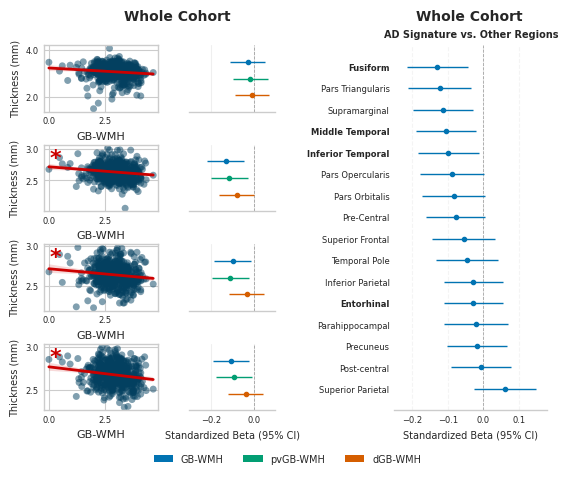

In [42]:

# Re-parse with the corrected function
betas_gb, errors_gb = parse_beta_ci(z_score_res_gb["GB-WMH"]["Beta (95% CI)"])
betas_dgb, errors_dgb = parse_beta_ci(z_score_res_dgb["GB-WMH"]["Beta (95% CI)"])
betas_pvgb, errors_pvgb = parse_beta_ci(z_score_res_pvgb["GB-WMH"]["Beta (95% CI)"])
betas_gb_others, errors_gb_others = parse_beta_ci(z_score_res_gb_others["GB-WMH"]["Beta (95% CI)"])

# Combine region names
all_region_labels = region_names_adsig + region_names_control

# Combine betas and errors (assuming same order in regions)
combined_betas = np.concatenate([betas_gb, betas_gb_others])
combined_errors = np.concatenate([errors_gb[0], errors_gb_others[0]])

# Create a cleaner and more publication-ready figure
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig = plt.figure(figsize=(6.5, 5))
    gs = gridspec.GridSpec(4, 4, width_ratios=[0.6, .45, 0.3, .8], wspace=0.3, hspace=0.5)
    
    # Define color palette - colorblind-friendly and more professional
    colors = {
        'Global': '#0173B2',         # Strong blue
        'Periventricular': '#029E73', # Green
        'Deep': '#D55E00',           # Vermillion
        'Scatter': '#034060',        # Dark blue for scatter points
        'Regression': '#CC0000'      # Darker red for regression line
    }
    
    significant_regions = {
        'whole': [1, 2, 3],           # Indices of significant regions for whole cohort
        'amyloid_pos': [0, 1, 2, 3],  # Indices of significant regions for amyloid-negative
    }
    
    # Format for consistent decimal places in y-ticks
    y_formatter = ticker.FormatStrFormatter('%.1f')
    plt.rc('xtick', labelsize=6)
    plt.rc('ytick', labelsize=6)
    # Create plots for each region
    for i, region in enumerate(adsig_avg_mayo):
        # Regression plot for whole cohort
        ax1 = fig.add_subplot(gs[i, 0])
        sns.regplot(
            x="wmh_vol_log", y=f"{region}_THICKNESS", 
            data=df_m00,  # Use your actual dataframe
            scatter_kws={"s": 25, "color": colors['Scatter'], "alpha": 0.5, "edgecolor": "none"}, 
            line_kws={"color": colors['Regression'], "lw": 2},
            ax=ax1
        )
        
        # Set y-label only with region name on first column
        if i == 0:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
        elif i == 1:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
        elif i == 2:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
        elif i == 3:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
            
        # Format y-ticks consistently
        ax1.yaxis.set_major_formatter(y_formatter)
        
        ax1.set_xlabel("GB-WMH", fontsize=8)
        
        # Add significance marker if appropriate
        if i in significant_regions['whole']:
            ax1.text(0.05, 0.95, "*", transform=ax1.transAxes, fontsize=16, 
                    fontweight='bold', color=colors['Regression'], ha='left', va='top')
        
        # Error bar plot for whole cohort (forest plot)
        ax2 = fig.add_subplot(gs[i, 1])
        
        ax2.grid(axis='y', linestyle='-', alpha=0.3)
        ax2.grid(axis='x', linestyle='-', alpha=0.3)
        
        # Plot zero line
        ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1, linewidth=0.6)
        
        # Plot error bars with offset for visibility - use a horizontal arrangement
        x_offsets = [0.25, 0, -0.25]  # Offsets for different measurement types
        
        # Plot for whole cohort
        ax2.errorbar(
            betas_gb[i], x_offsets[0], xerr=errors_gb[0, i], 
            fmt='o', color=colors['Global'], capsize=0, 
            markersize=3, elinewidth=1, capthick=1,
            label='Global WMH' if i == 0 else ""
        )
        ax2.errorbar(
            betas_pvgb[i], x_offsets[1], xerr=errors_pvgb[0, i], 
            fmt='o', color=colors['Periventricular'], capsize=0, 
            markersize=3, elinewidth=1, capthick=1,
            label='Periventricular WMH' if i == 0 else ""
        )
        ax2.errorbar(
            betas_dgb[i], x_offsets[2], xerr=errors_dgb[0, i], 
            fmt='o', color=colors['Deep'], capsize=0, 
            markersize=3, elinewidth=1, capthick=1,
            label='Deep WMH' if i == 0 else ""
        )
        
        # Set limits and remove spines for cleaner look
        ax2.set_xlim(-0.30, 0.1)
        ax2.set_ylim(-0.5, 0.5)
        ax2.set_yticks([])
        
        # Only show x labels on bottom plot
        if i == 3:
            ax2.set_xlabel('Standardized Beta (95% CI)', fontsize=7)
        else:
            ax2.set_xticklabels([])
            
        # Remove unnecessary spines
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)

        ax3 = fig.add_subplot(gs[i, 2])
        ax3.axis("off")  # Turn off axis lines and labels for this column
        
    # Sort combined forest plot data
    sorted_indices = np.argsort(combined_betas)
    sorted_betas = combined_betas[sorted_indices]
    sorted_errors = combined_errors[sorted_indices]
    sorted_labels = [all_region_labels[i] for i in sorted_indices]
    sorted_weights = ['bold' if label in region_names_adsig else 'normal' for label in sorted_labels]

    # Move forest plot to the second column (index 1), shift error bars to column 2
    ax_combined = fig.add_subplot(gs[:, 3])

    y_positions = np.arange(len(sorted_labels))[::-1]

    for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas, sorted_errors, y_positions, sorted_weights)):
        ax_combined.errorbar(
            beta, y,
            xerr=err, fmt='o', color=colors["Global"], capsize=0,
            markersize=3, elinewidth=1, capthick=1,
            zorder=2
        )

    # Format plot
    ax_combined.axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1, linewidth=0.6)
    ax_combined.set_yticks(y_positions)
    ax_combined.set_yticklabels(sorted_labels, fontsize=6, fontweight='normal')

    # Apply bold font to AD signature regions
    for tick_label, weight in zip(ax_combined.get_yticklabels(), sorted_weights):
        tick_label.set_fontweight(weight)

    ax_combined.set_xlabel('Standardized Beta (95% CI)', fontsize=7)
    ax_combined.set_xlim(-0.25, 0.18)
    ax_combined.set_ylim(-1, len(sorted_labels))
    ax_combined.tick_params(axis='x', labelsize=6)
    ax_combined.grid(False, axis='y')
    ax_combined.grid(axis='x', linestyle='--', alpha=0.2)
    ax_combined.spines['top'].set_visible(False)
    ax_combined.spines['right'].set_visible(False)
    ax_combined.spines['left'].set_visible(False)
    ax_combined.set_title("AD Signature vs. Other Regions", fontsize=7, fontweight='bold', loc='center')
 
    # Add common legend for the error bar plots
    handles = [
        Patch(facecolor=colors['Global'], label='GB-WMH'),
        Patch(facecolor=colors['Periventricular'], label='pvGB-WMH'),
        Patch(facecolor=colors['Deep'], label='dGB-WMH')
    ]
    leg = fig.legend(
        handles=handles, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.08), 
        ncol=3, 
        frameon=False, 
        fontsize=7
    )
    # Add column titles - adjust position to match the new layout
    fig.text(0.33, 0.93, "Whole Cohort", ha='center', fontsize=10, fontweight='bold')
    fig.text(0.78, 0.93, "Whole Cohort", ha='center', fontsize=10, fontweight='bold')
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    fig.savefig(FIGURES_DIR / "whole_cohort_wmh_thickness_reg_forestplot.svg", dpi=300)

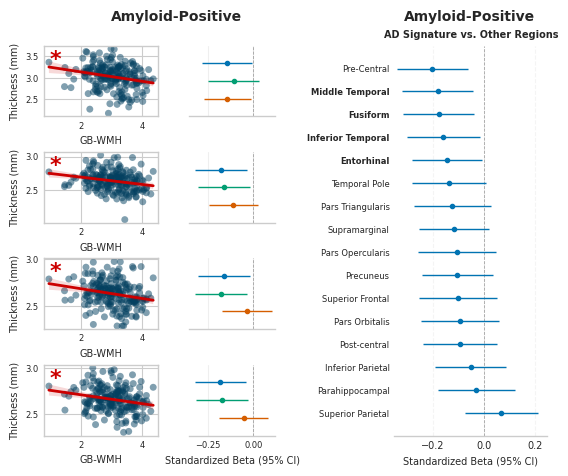

In [43]:
betas_gb_amy, errors_gb_amy = parse_beta_ci(z_score_res_gb_amy["GB-WMH"]["Beta (95% CI)"])
betas_gb_others_amy, errors_gb_others_amy = parse_beta_ci(z_score_res_gb_others_amy["GB-WMH"]["Beta (95% CI)"])

betas_gb_amy_neg, errors_gb_amy_neg = parse_beta_ci(z_score_res_gb_amy_neg["GB-WMH"]["Beta (95% CI)"])
betas_gb_others_amy_neg, errors_gb_others_amy_neg = parse_beta_ci(z_score_res_gb_others_amy_neg["GB-WMH"]["Beta (95% CI)"])

# Combine betas and errors (assuming same order in regions)
combined_betas_amy = np.concatenate([betas_gb_amy, betas_gb_others_amy])
combined_errors_amy = np.concatenate([errors_gb_amy[0], errors_gb_others_amy[0]])

combined_betas_amy_neg = np.concatenate([betas_gb_amy_neg, betas_gb_others_amy_neg])
combined_errors_amy_neg = np.concatenate([errors_gb_amy_neg[0], errors_gb_others_amy_neg[0]])

# Create a cleaner and more publication-ready figure
with plt.style.context('seaborn-v0_8-whitegrid'):
    fig = plt.figure(figsize=(6.5, 5))
    gs = gridspec.GridSpec(4, 4, width_ratios=[0.6, .45, 0.3, .8], wspace=0.3, hspace=0.5)
    
    # Format for consistent decimal places in y-ticks
    y_formatter = ticker.FormatStrFormatter('%.1f')
    # Set all tick label fonts to size 9
    plt.rc('xtick', labelsize=6)
    plt.rc('ytick', labelsize=6)
    # Create plots for each region
    for i, region in enumerate(adsig_avg_mayo):
        # Regression plot for whole cohort
        ax1 = fig.add_subplot(gs[i, 0])
        sns.regplot(
            x="wmh_vol_log", y=f"{region}_THICKNESS", 
            data=df_m00_amy,  # Use your actual dataframe
            scatter_kws={"s": 25, "color": colors['Scatter'], "alpha": 0.5, "edgecolor": "none"}, 
            line_kws={"color": colors['Regression'], "lw": 2},
            ax=ax1
        )
        
        # Set y-label only with region name on first column
        if i == 0:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
        elif i == 1:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
        elif i == 2:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
        elif i == 3:
            ax1.set_ylabel("Thickness (mm)", fontsize=7)
            
        # Format y-ticks consistently
        ax1.yaxis.set_major_formatter(y_formatter)
        
        ax1.set_xlabel("GB-WMH", fontsize=7)
        
        # Add significance marker if appropriate
        if i in significant_regions['amyloid_pos']:
            ax1.text(0.05, 0.95, "*", transform=ax1.transAxes, fontsize=16, 
                    fontweight='bold', color=colors['Regression'], ha='left', va='top')
        
        # Error bar plot for whole cohort (forest plot)
        ax2 = fig.add_subplot(gs[i, 1])
        
        ax2.grid(axis='y', linestyle='-', alpha=0.3)
        ax2.grid(axis='x', linestyle='-', alpha=0.3)
        
        # Plot zero line
        ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1, linewidth=0.6)
        
        # Plot error bars with offset for visibility - use a horizontal arrangement
        x_offsets = [0.25, 0, -0.25]  # Offsets for different measurement types
        
        ax2.errorbar(
            betas_gb_amy[i], x_offsets[0], xerr=errors_gb_amy[0, i], 
            fmt='o', color=colors['Global'], capsize=0, 
            markersize=3, elinewidth=1, capthick=1,
            label='Global WMH' if i == 0 else ""
        )
        ax2.errorbar(
            betas_pvgb_amy[i], x_offsets[1], xerr=errors_pvgb_amy[0, i], 
            fmt='o', color=colors['Periventricular'], capsize=0, 
            markersize=3, elinewidth=1, capthick=1,
            label='Periventricular WMH' if i == 0 else ""
        )
        ax2.errorbar(
            betas_dgb_amy[i], x_offsets[2], xerr=errors_dgb_amy[0, i], 
            fmt='o', color=colors['Deep'], capsize=0, 
            markersize=3, elinewidth=1, capthick=1,
            label='Deep WMH' if i == 0 else ""
        )
        
        # Set limits and remove spines for cleaner look
        ax2.set_xlim(-0.35, 0.12)
        ax2.set_ylim(-0.5, 0.5)
        ax2.set_yticks([])
        
        # Only show x labels on bottom plot
        if i == 3:
            ax2.set_xlabel('Standardized Beta (95% CI)', fontsize=7)
        else:
            ax2.set_xticklabels([])
            
        # Remove unnecessary spines
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)

        ax3 = fig.add_subplot(gs[i, 2])
        ax3.axis("off")  # Turn off axis lines and labels for this column
        
    # Sort combined forest plot data
    sorted_indices = np.argsort(combined_betas_amy)
    sorted_betas_amy = combined_betas_amy[sorted_indices]
    sorted_errors_amy = combined_errors_amy[sorted_indices]

    # sorted_betas_amy_neg = combined_betas_amy_neg[sorted_indices]
    # sorted_errors_amy_neg = combined_errors_amy_neg[sorted_indices]

    sorted_labels = [all_region_labels[i] for i in sorted_indices]
    sorted_weights = ['bold' if label in region_names_adsig else 'normal' for label in sorted_labels]

    # Move forest plot to the second column (index 1), shift error bars to column 2
    ax_combined = fig.add_subplot(gs[:, 3])

    y_positions = np.arange(len(sorted_labels))[::-1]

    for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas_amy, sorted_errors_amy, y_positions, sorted_weights)):
        ax_combined.errorbar(
            beta, y,
            xerr=err, fmt='o', color=colors["Global"], capsize=0,
            markersize=3, elinewidth=1, capthick=1,
            zorder=2
        )
    # for idx, (beta, err, y, weight) in enumerate(zip(sorted_betas_amy_neg, sorted_errors_amy_neg, y_positions, sorted_weights)):
    #             ax_combined.errorbar(
    #         beta, y-0.3,
    #         xerr=err, fmt='^', color="#003f7f", capsize=0,
    #         markersize=4, elinewidth=1, capthick=1,
    #         zorder=2
    #     )

    # Format plot
    ax_combined.axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1, linewidth=0.6)
    ax_combined.set_yticks(y_positions)
    ax_combined.set_yticklabels(sorted_labels, fontsize=6, fontweight='normal')

    # Apply bold font to AD signature regions
    for tick_label, weight in zip(ax_combined.get_yticklabels(), sorted_weights):
        tick_label.set_fontweight(weight)

    ax_combined.set_xlabel('Standardized Beta (95% CI)', fontsize=7)
    ax_combined.set_xlim(-0.35, 0.25)
    ax_combined.set_ylim(-1, len(sorted_labels))
    ax_combined.tick_params(axis='x', labelsize=7)
    ax_combined.grid(False, axis='y')
    ax_combined.grid(axis='x', linestyle='--', alpha=0.2)
    ax_combined.spines['top'].set_visible(False)
    ax_combined.spines['right'].set_visible(False)
    ax_combined.spines['left'].set_visible(False)
    ax_combined.set_title("AD Signature vs. Other Regions", fontsize=7, fontweight='bold', loc='center')
    
    # Add column titles - adjust position to match the new layout
    fig.text(0.33, 0.93, "Amyloid-Positive", ha='center', fontsize=10, fontweight='bold')
    fig.text(0.78, 0.93, "Amyloid-Positive", ha='center', fontsize=10, fontweight='bold')
    
    plt.subplots_adjust(bottom=0.1)  # Make room for the legend
    fig.savefig(FIGURES_DIR / "amyloid_wmh_thickness_reg_forestplot.svg", dpi=300)

/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


r:0.63, p:0.00
r:0.59, p:0.00
r:0.54, p:0.00
r:0.69, p:0.00


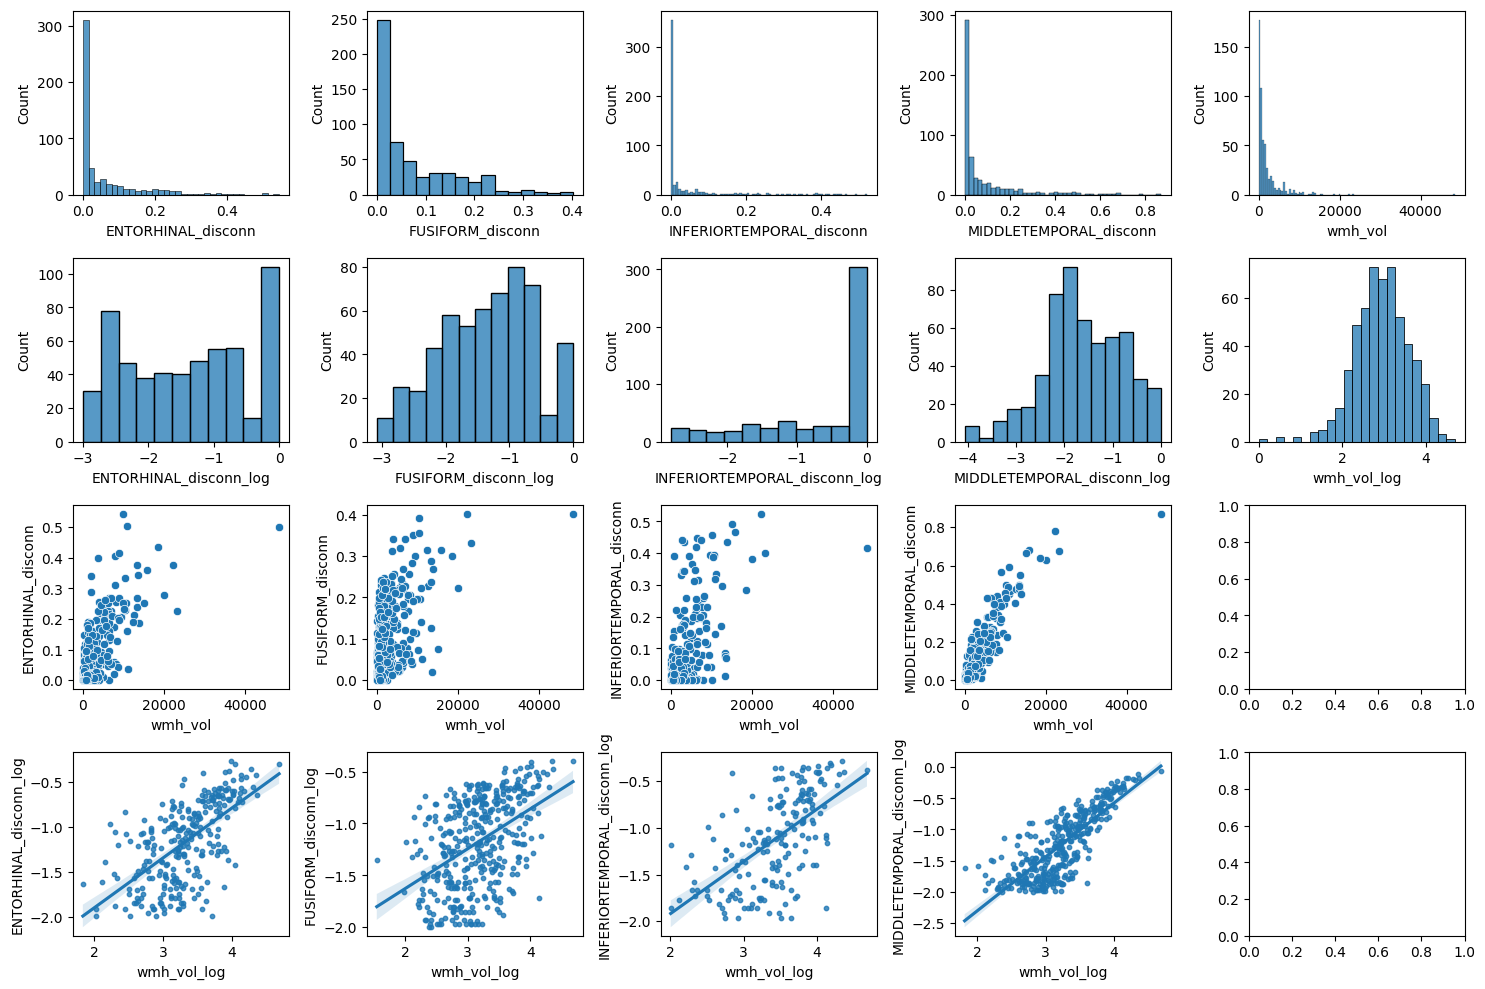

In [44]:

for region in adsig_avg_mayo:
    disconn = region + "_disconn"
    disconn_log = region + "_disconn_log"
    df_m00[disconn_log] = np.log10(df_m00[disconn], out = np.zeros_like(df_m00[disconn]), where=(df_m00[disconn] != 0))

fig, axs = plt.subplots(4, 5, figsize = (15, 10))
from scipy.stats import pearsonr
for i, region in enumerate(adsig_avg_mayo):

    disconn = region + "_disconn"
    disconn_log = region + "_disconn_log"
    r, p = pearsonr(df_m00[disconn], df_m00[df_m00["session"] == "M00"]["wmh_vol_log"])
    print(f"r:{r:.2f}, p:{p:.2f}")
    
    sns.histplot(data=df_m00, x = disconn, ax = axs[0, i])
    sns.histplot(data=df_m00, x = disconn_log, ax = axs[1, i])
    sns.scatterplot(data=df_m00, y = disconn, x = "wmh_vol", ax = axs[2, i])
    sns.regplot(data=df_m00[df_m00[disconn] > 0.01], y = disconn_log, x = "wmh_vol_log", ax = axs[3, i], scatter_kws = {"s":10}, order=1)

sns.histplot(data=df_m00, x = "wmh_vol", ax = axs[0, 4])
sns.histplot(data=df_m00, x = "wmh_vol_log", ax = axs[1, 4])
fig.tight_layout()

In [45]:
# get the residual
for i, region in enumerate(adsig_avg_mayo):
    
    disconn = region + "_disconn"
    disconn_log= region + "_disconn_log"
    disconn_ratio = disconn + "_ratio"
    m = smf.ols(data = df_m00[df_m00[disconn] > 0.01], formula = f"{disconn_log} ~ wmh_vol_log")
    s = m.fit()
    df_m00[disconn_ratio] = s.resid

In [46]:
calculate_cross_sectional_associations(df_m00, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_disconn")

FB-WMH                                            \
              region      N           Beta (95% CI) p-val p-val (FDR)   
0         Entorhinal    269   0.048 (-0.047, 0.143)  0.32        0.58   
1           Fusiform    392  -0.012 (-0.042, 0.018)  0.44        0.58   
2  Inferior temporal    184   0.031 (-0.015, 0.076)  0.19        0.58   
3    Middle temporal    356   0.003 (-0.037, 0.042)  0.89        0.89   

                  Amyloid                                         Tau  \
            Beta (95% CI)  p-val p-val (FDR)            Beta (95% CI)   
0   0.265 (-0.023, 0.553)  0.072        0.14  -0.327 (-0.426, -0.228)   
1    0.076 (0.008, 0.144)  0.028        0.11  -0.102 (-0.134, -0.070)   
2  -0.017 (-0.100, 0.066)   0.69         0.8  -0.065 (-0.105, -0.024)   
3  -0.007 (-0.066, 0.052)    0.8         0.8  -0.077 (-0.108, -0.046)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2      0.0018      0.0018  
3  p < 0.0001  p < 0.0001

In [47]:
calculate_cross_sectional_associations(df_m00[df_m00["AMYLOID_STATUS"] == 1], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_disconn")

FB-WMH                                            \
              region      N           Beta (95% CI) p-val p-val (FDR)   
0         Entorhinal    115   0.037 (-0.107, 0.181)  0.62        0.76   
1           Fusiform    161   0.009 (-0.047, 0.064)  0.76        0.76   
2  Inferior temporal     78   0.067 (-0.019, 0.152)  0.12         0.5   
3    Middle temporal    142  -0.025 (-0.101, 0.051)  0.51        0.76   

                  Amyloid                                        Tau  \
            Beta (95% CI) p-val p-val (FDR)            Beta (95% CI)   
0   0.057 (-0.359, 0.473)  0.79        0.79  -0.262 (-0.381, -0.143)   
1   0.051 (-0.064, 0.166)  0.39        0.79  -0.104 (-0.144, -0.065)   
2  -0.040 (-0.201, 0.120)  0.62        0.79  -0.054 (-0.107, -0.000)   
3  -0.016 (-0.121, 0.089)  0.76        0.79  -0.089 (-0.126, -0.051)   

                           
        p-val p-val (FDR)  
0  p < 0.0001  p < 0.0001  
1  p < 0.0001  p < 0.0001  
2       0.049       0.049  
3  p < 0.0001  p < 0.0001

In [48]:
adsig_avg_mayo = []

for region in adsig_mayo:
    region_name = region.split("_")[-1]
    left_region = f"CTX_LH_{region_name}"
    right_region = f"CTX_RH_{region_name}"
    df_l[f"{region_name}_disconn"] = (
        df_l[f"{left_region}_disconn"] + df_l[f"{right_region}_disconn"]
    ) / 2
    df_l[f"{region_name}_THICKNESS"] = (
        df_l[f"{left_region}_THICKNESS"] + df_l[f"{right_region}_THICKNESS"]
    ) / 2
    df_l[f"{region_name}_SUVR_tau"] = (
        df_l[f"{left_region}_SUVR_tau"] + df_l[f"{right_region}_SUVR_tau"]
    ) / 2
    df_l[f"{region_name}_SUVR_amy"] = (
        df_l[f"{left_region}_SUVR_amy"] + df_l[f"{right_region}_SUVR_amy"]
    ) / 2
    if not region_name in adsig_avg_mayo:
        adsig_avg_mayo.append(region_name)

adsig_avg_control = []

for region in adsig_control:
    region_name = region.split("_")[-1]
    left_region = f"CTX_LH_{region_name}"
    right_region = f"CTX_RH_{region_name}"
    df_l[f"{region_name}_disconn"] = (
        df_l[f"{left_region}_disconn"] + df_l[f"{right_region}_disconn"]
    ) / 2
    df_l[f"{region_name}_THICKNESS"] = (
        df_l[f"{left_region}_THICKNESS"] + df_l[f"{right_region}_THICKNESS"]
    ) / 2
    df_l[f"{region_name}_SUVR_tau"] = (
        df_l[f"{left_region}_SUVR_tau"] + df_l[f"{right_region}_SUVR_tau"]
    ) / 2
    df_l[f"{region_name}_SUVR_amy"] = (
        df_l[f"{left_region}_SUVR_amy"] + df_l[f"{right_region}_SUVR_amy"]
    ) / 2
    if not region_name in adsig_avg_control:
        adsig_avg_control.append(region_name)


for i, region in enumerate(adsig_avg_mayo):
    
    disconn = region + "_disconn"
    disconn_log= region + "_disconn_log"
    disconn_ratio = disconn + "_ratio"
    df_l[disconn_log] = np.log10(df_l[disconn], out = np.zeros_like(df_l[disconn]), where=(df_l[disconn] != 0))
    m = smf.ols(data = df_l[df_l[disconn] > 0.01], formula = f"{disconn_log} ~ wmh_vol_log")
    s = m.fit()
    df_l[disconn_ratio] = s.resid

thresh_wmh = df_m00["wmh_vol_log"].quantile(0.66)
high_wmh_subjs = df_m00[df_m00["wmh_vol_log"] > thresh_wmh]["PTID"]
amy_pos_long = df_l[(df_l["AMYLOID_STATUS"]==1) & (df_l["session"]=="M00")]["PTID"]

print("---------------------------------------------")
print("GB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))
print("---------------------------------------------")
print("pvGB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l, adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis"))
print("---------------------------------------------")
print("dGB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l, adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis"))
print("---------------------------------------------")
print("FB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_disconn"))

/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


---------------------------------------------
GB-WMH
---------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal    125  -0.001 (-0.011, 0.010)    0.92  0.92
1           Fusiform    125   0.002 (-0.004, 0.007)    0.50  0.92
2  Inferior temporal    125  -0.000 (-0.005, 0.005)    0.91  0.92
3    Middle temporal    125  -0.001 (-0.006, 0.003)    0.55  0.92

---------------------------------------------
pvGB-WMH
---------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal    125  -0.003 (-0.013, 0.006)    0.48  0.64
1           Fusiform    125  -0.000 (-0.005, 0.004)    0.90  0.90
2  Inferior temporal    125  -0.002 (-0.006, 0.003)    0.44  0.64
3    Middle temporal    125  -0.002 (-0.006, 0.002)    0.34  0.64

---------------------------------------------
dGB-WMH
---------------------------------------------


GB-WMH                                     
              region      N          Beta (95% CI) p-value FDR-p
0         Entorhinal    125   0.008 (0.000, 0.016)    0.04  0.16
1           Fusiform    125  0.003 (-0.001, 0.007)    0.12  0.16
2  Inferior temporal    125  0.003 (-0.001, 0.006)    0.11  0.16
3    Middle temporal    125  0.001 (-0.003, 0.004)    0.69  0.69

---------------------------------------------
FB-WMH
---------------------------------------------


FB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     61   0.006 (-0.024, 0.035)    0.70  0.81
1           Fusiform     84   0.008 (-0.002, 0.019)    0.11  0.35
2  Inferior temporal     34  -0.002 (-0.016, 0.012)    0.81  0.81
3    Middle temporal     72  -0.010 (-0.024, 0.004)    0.18  0.35

In [49]:
print("---------------------------------------------")
print("GB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(amy_pos_long)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))
print("---------------------------------------------")
print("pvGB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(amy_pos_long)], adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis"))
print("---------------------------------------------")
print("dGB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(amy_pos_long)], adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis"))
print("---------------------------------------------")
print("FB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(amy_pos_long)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_disconn"))

---------------------------------------------
GB-WMH
---------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     48  -0.006 (-0.028, 0.016)    0.60  0.65
1           Fusiform     48   0.003 (-0.008, 0.015)    0.57  0.65
2  Inferior temporal     48  -0.003 (-0.014, 0.009)    0.65  0.65
3    Middle temporal     48  -0.005 (-0.015, 0.005)    0.31  0.65

---------------------------------------------
pvGB-WMH
---------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     48  -0.009 (-0.028, 0.010)    0.34  0.56
1           Fusiform     48   0.000 (-0.010, 0.010)    0.98  0.98
2  Inferior temporal     48  -0.004 (-0.014, 0.006)    0.42  0.56
3    Middle temporal     48  -0.005 (-0.014, 0.004)    0.26  0.56

---------------------------------------------
dGB-WMH
---------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     48   0.002 (-0.017, 0.021)    0.85  0.85
1           Fusiform     48   0.004 (-0.006, 0.014)    0.43  0.85
2  Inferior temporal     48   0.002 (-0.007, 0.012)    0.62  0.85
3    Middle temporal     48  -0.002 (-0.011, 0.007)    0.66  0.85

---------------------------------------------
FB-WMH
---------------------------------------------


FB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     30   0.009 (-0.045, 0.064)    0.74  0.75
1           Fusiform     37  -0.003 (-0.023, 0.017)    0.75  0.75
2  Inferior temporal     18  -0.007 (-0.046, 0.031)    0.71  0.75
3    Middle temporal     31  -0.020 (-0.057, 0.018)    0.30  0.75

In [50]:
print("---------------------------------------------")
print("GB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(high_wmh_subjs)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis"))
print("---------------------------------------------")
print("pvGB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(high_wmh_subjs)], adsig_avg_mayo, region_names_adsig, "wmh_vol_pv_log", analysis_type="basis"))
print("---------------------------------------------")
print("dGB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(high_wmh_subjs)], adsig_avg_mayo, region_names_adsig, "wmh_vol_deep_log", analysis_type="basis"))
print("---------------------------------------------")
print("FB-WMH")
print("---------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(high_wmh_subjs)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="basis_disconn"))

---------------------------------------------
GB-WMH
---------------------------------------------


GB-WMH                                       
              region      N            Beta (95% CI) p-value FDR-p
0         Entorhinal     37   -0.011 (-0.056, 0.033)    0.61  0.68
1           Fusiform     37   -0.004 (-0.025, 0.016)    0.68  0.68
2  Inferior temporal     37  -0.021 (-0.042, -0.001)    0.04  0.18
3    Middle temporal     37   -0.013 (-0.032, 0.006)    0.17  0.34

---------------------------------------------
pvGB-WMH
---------------------------------------------


GB-WMH                                       
              region      N            Beta (95% CI) p-value FDR-p
0         Entorhinal     37   -0.024 (-0.067, 0.018)    0.27  0.35
1           Fusiform     37   -0.009 (-0.029, 0.011)    0.40  0.40
2  Inferior temporal     37  -0.023 (-0.043, -0.004)    0.02  0.08
3    Middle temporal     37   -0.015 (-0.033, 0.002)    0.09  0.18

---------------------------------------------
dGB-WMH
---------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     37   0.010 (-0.012, 0.032)    0.37  0.93
1           Fusiform     37   0.003 (-0.007, 0.014)    0.52  0.93
2  Inferior temporal     37  -0.002 (-0.013, 0.009)    0.69  0.93
3    Middle temporal     37   0.000 (-0.009, 0.010)    0.96  0.96

---------------------------------------------
FB-WMH
---------------------------------------------


/home/leoner/miniconda3/envs/cat_whim/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


FB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     32   0.033 (-0.006, 0.073)    0.10  0.19
1           Fusiform     36    0.017 (0.002, 0.031)    0.03  0.10
2  Inferior temporal     23  -0.011 (-0.032, 0.009)    0.27  0.27
3    Middle temporal     36  -0.018 (-0.044, 0.008)    0.18  0.24

In [51]:
all_amy_cols = [col + "_SUVR_amy" for col in dk_region_labels]
all_tau_cols = [col + "_SUVR_tau" for col in dk_region_labels]

df_l["global_amy"] = df_l[all_amy_cols].mean(axis=1)
df_l["global_tau"] = df_l[all_tau_cols].mean(axis=1)

print("-----------------------------------------------------")
print("sensitivity analysis for global tau-amy, whole-cohort")
print("-----------------------------------------------------")
display(calculate_longitudinal_associations(df_l, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="global_tau_amy"))
print("-----------------------------------------------------")
print("sensitivity analysis for global tau-amy, amyloid-positive")
print("-----------------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(amy_pos_long)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="global_tau_amy"))
print("-----------------------------------------------------")
print("sensitivity analysis for global tau-amy, high WMH")
print("-----------------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(high_wmh_subjs)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="global_tau_amy"))

-----------------------------------------------------
sensitivity analysis for global tau-amy, whole-cohort
-----------------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal    125  -0.000 (-0.011, 0.010)    0.95  1.00
1           Fusiform    125   0.002 (-0.003, 0.008)    0.42  1.00
2  Inferior temporal    125  -0.000 (-0.005, 0.005)    1.00  1.00
3    Middle temporal    125  -0.001 (-0.005, 0.003)    0.64  1.00

-----------------------------------------------------
sensitivity analysis for global tau-amy, amyloid-positive
-----------------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     48  -0.005 (-0.027, 0.017)    0.64  0.64
1           Fusiform     48   0.003 (-0.008, 0.015)    0.55  0.64
2  Inferior temporal     48  -0.003 (-0.014, 0.008)    0.64  0.64
3    Middle temporal     48  -0.005 (-0.015, 0.004)    0.30  0.64

-----------------------------------------------------
sensitivity analysis for global tau-amy, high WMH
-----------------------------------------------------


GB-WMH                                       
              region      N            Beta (95% CI) p-value FDR-p
0         Entorhinal     37   -0.010 (-0.056, 0.036)    0.67  0.67
1           Fusiform     37   -0.005 (-0.026, 0.016)    0.65  0.67
2  Inferior temporal     37  -0.021 (-0.041, -0.001)    0.04  0.16
3    Middle temporal     37   -0.012 (-0.030, 0.006)    0.18  0.35

In [52]:
print("-----------------------------------------------------")
print("sensitivity analysis for less covariates, whole-cohort")
print("-----------------------------------------------------")
display(calculate_longitudinal_associations(df_l, adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="sensitivity_less_covariates"))
print("-----------------------------------------------------")
print("sensitivity analysis for less covariates, amyloid-positive")
print("-----------------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(amy_pos_long)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="sensitivity_less_covariates"))
print("-----------------------------------------------------")
print("sensitivity analysis for less covariates, high WMH")
print("-----------------------------------------------------")
display(calculate_longitudinal_associations(df_l[df_l["PTID"].isin(high_wmh_subjs)], adsig_avg_mayo, region_names_adsig, "wmh_vol_log", analysis_type="sensitivity_less_covariates"))

-----------------------------------------------------
sensitivity analysis for less covariates, whole-cohort
-----------------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal    125  -0.001 (-0.011, 0.010)    0.91  0.91
1           Fusiform    125   0.002 (-0.004, 0.007)    0.50  0.91
2  Inferior temporal    125  -0.000 (-0.005, 0.005)    0.90  0.91
3    Middle temporal    125  -0.001 (-0.006, 0.003)    0.55  0.91

-----------------------------------------------------
sensitivity analysis for less covariates, amyloid-positive
-----------------------------------------------------


GB-WMH                                      
              region      N           Beta (95% CI) p-value FDR-p
0         Entorhinal     48  -0.006 (-0.027, 0.016)    0.62  0.65
1           Fusiform     48   0.003 (-0.008, 0.015)    0.58  0.65
2  Inferior temporal     48  -0.003 (-0.014, 0.009)    0.65  0.65
3    Middle temporal     48  -0.005 (-0.015, 0.005)    0.32  0.65

-----------------------------------------------------
sensitivity analysis for less covariates, high WMH
-----------------------------------------------------


GB-WMH                                       
              region      N            Beta (95% CI) p-value FDR-p
0         Entorhinal     37   -0.011 (-0.056, 0.033)    0.62  0.71
1           Fusiform     37   -0.004 (-0.025, 0.017)    0.71  0.71
2  Inferior temporal     37  -0.021 (-0.042, -0.000)    0.05  0.18
3    Middle temporal     37   -0.013 (-0.032, 0.006)    0.17  0.35

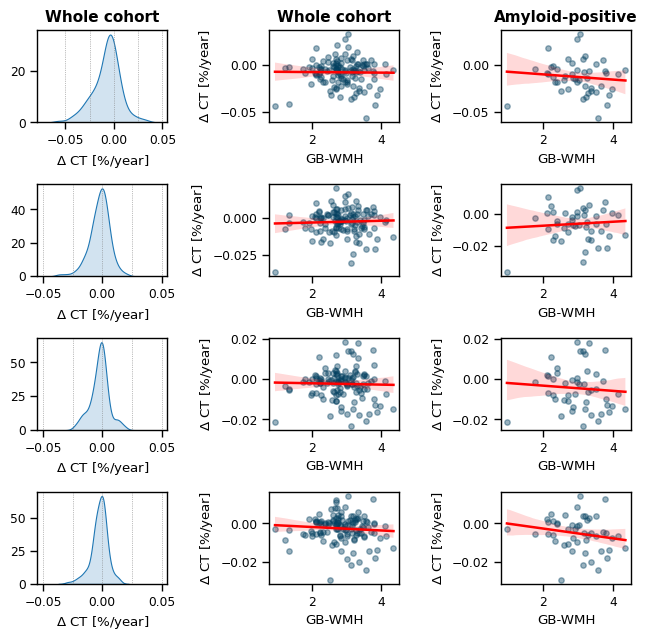

In [53]:
subjs_with_fu = df_l[df_l["session"] == "M01"]["PTID"].unique()  # Filter subjects with follow-up (M01)
df_long = df_l[df_l["PTID"].isin(subjs_with_fu)].copy()  # Filter for these subjects

with sns.plotting_context("paper", font_scale=1):

    fig, axs = plt.subplots(4, 3, figsize=(6.5, 6.5))

    for i, region in enumerate(adsig_avg_mayo):

        # Define region-specific columns
        thickness = region + "_THICKNESS"
        thickness_delta = thickness + "_delta_annualized"
        disconn = region + "_disconn"
        tau = region + "_SUVR_tau"

        # Step 1: Pivot the data to separate M00 and M01 sessions
        df_pivot = df_long.pivot_table(
            index="PTID",        # Unique participant identifier
            columns="session",   # Separate M00 and M01 into columns
            values=["Years_m00", "wmh_vol_log", thickness, disconn]  # Relevant columns
        )
        # Flatten the multi-level column index for easier access
        df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns]

        # Step 2: Calculate the annualized rate of change for cortical thickness
        df_pivot[f"{thickness}_delta_annualized"] = (
            (df_pivot[f"{thickness}_M01"] - df_pivot[f"{thickness}_M00"]) /
            (df_pivot[f"{thickness}_M00"] * df_pivot["Years_m00_M01"])
        )

        sns.kdeplot(
            data=df_pivot,
            x=f"{thickness}_delta_annualized",  # Annualized cortical thickness change
            ax=axs[i, 0],
            fill=True,
            alpha=0.2,
        )
        axs[i, 1].set_ylabel(r"$\Delta$ CT [%/year]")
        axs[i, 1].set_xlabel("GB-WMH")

        # Define the range for vertical lines
        start_value = -0.05  # Starting x-coordinate
        end_value = 0.05    # Ending x-coordinate

        # Calculate equally spaced positions for 5 lines
        num_lines = 5
        line_positions = np.linspace(start_value, end_value, num_lines)

        # Add vertical dotted lines
        for x in line_positions:
            axs[i, 0].axvline(x, color="grey", linestyle="dotted", linewidth=0.5)

        axs[i, 0].set_xlabel(r"$\Delta$ CT [%/year]")
        axs[i, 0].set_ylabel("")

        sns.regplot(
            data=df_pivot,
            x="wmh_vol_log_M00",  # Global WMH volume at M00
            y=f"{thickness}_delta_annualized",  # Annualized cortical thickness change
            scatter_kws={"s": 15, "color": "#034060", "alpha": 0.4},  # Dark blue
            line_kws={"color": "red"},  # Regression line in red
            ax=axs[i, 1]
        )
        axs[i, 1].set_ylabel(r"$\Delta$ CT [%/year]")
        axs[i, 1].set_xlabel("GB-WMH")

        sns.regplot(
            data=df_pivot[df_pivot.index.isin(amy_pos_long)],
            x="wmh_vol_log_M00",  # Global WMH volume at M00
            y=f"{thickness}_delta_annualized",  # Annualized cortical thickness change
            scatter_kws={"s": 15, "color": "#034060", "alpha": 0.4},  # Dark blue
            line_kws={"color": "red"},  # Regression line in red
            ax=axs[i, 2]
        )
        axs[i, 2].set_ylabel(r"$\Delta$ CT [%/year]")
        axs[i, 2].set_xlabel("GB-WMH")
        if i == 0:
            axs[i, 0].set_title(f"Whole cohort", weight="bold", fontsize=11)
            axs[i, 1].set_title(f"Whole cohort", weight="bold", fontsize=11)
            axs[i, 2].set_title(f"Amyloid-positive", weight="bold", fontsize=11)
            
    
    # Adjust layout for better spacing between subplots
    fig.tight_layout()
    plt.savefig(REPORTS_DIR / "longitudinal_results.svg", dpi=500)


## Brain illustration for Figure 1

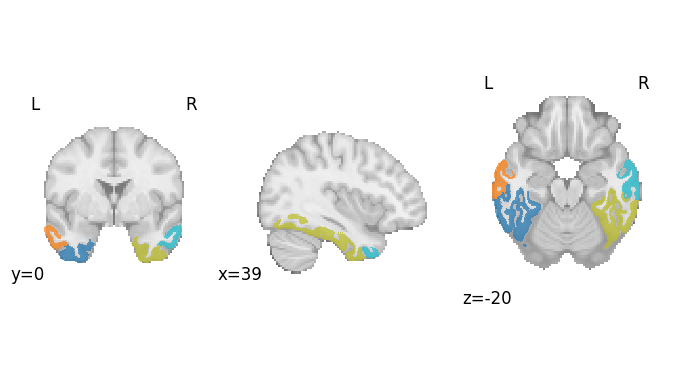

In [54]:
import abagen
import nibabel as nib
import nilearn.plotting as niplot

atlas = abagen.fetch_desikan_killiany()
atlas_nifti = nib.load(atlas["image"])
dk_arr = atlas_nifti.get_fdata()
ids = np.array([5, 6, 8, 14, 46, 47, 49, 55])
# Use np.isin to create a boolean mask for elements in dk_arr that are in ids_array
mask = np.isin(dk_arr, ids)s

# Set all values in dk_arr that are not in the mask to 0
dk_arr[~mask] = 0
new_dk = nib.Nifti1Image(dk_arr, atlas_nifti.affine, atlas_nifti.header)

niplot.plot_roi(new_dk, draw_cross=False, cmap="tab10", cut_coords = [39, 0, -20])
plt.savefig(REPORTS_DIR / "brain_dk_atlas.png", dpi = 500)